In [1]:
%%javascript

// turn on equation numbering for mathjax
MathJax.Hub.Config({
  TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

# MMDCritic

This notebook prototypes Been Kim's "MMD-Critic" algorithm [found here](http://people.csail.mit.edu/beenkim/papers/KIM2016NIPS_MMD.pdf).

Citation:

```
@inproceedings{kim2016MMD,
  title={Examples are not Enough, Learn to Criticize! Criticism for Interpretability},
  author={Been Kim, Rajiv Khanna and Sanmi Koyejo },
  booktitle={Advances in Neural Information Processing Systems},
  year={2016}
}
```


## Maximum Mean Discrepancy (MMD)

__*Brief excerpt from kim2016MMD*__

MMD-Critic leverages the maximum mean discrepancy (MMD) as a measure of the difference between distributions $\mathcal{P}$ and $\mathcal{Q}$, given by the sprenum over a function space $\mathcal{F}$ of differences between the expectations with respect to two distributions. The MMD is given by:

\begin{equation}
MMD(\mathcal{F, P, Q}) = \underset{f \in \mathcal{F}}{\textrm{sup}}(\textrm{E}_{X \sim P}[f(X)] - \textrm{E}_{Y \sim Q}[f(Y)])
\end{equation}

When $\mathcal{F}$ is a reproducing kernel Hilbert space (RKHS) with kernel function $k: \mathcal{X} \times \mathcal{X} \rightarrow \mathbb{R}$, the suprenum is achieved at:

\begin{equation}
f(x) = \textrm{E}_{X' \sim P}[k(x,X')] - \textrm{E}_{X' \sim Q}[k(x,X')]
\end{equation}

Function (2) is also known as the *witness function* as it measures the maximum discrepancy between the two expectations in $\mathcal{F}$. The witness function is positive whenever $\mathcal{Q}$ underfits the density of $\mathcal{P}$ and negative whenever $\mathcal{Q}$ overfits $\mathcal{P}$. We can substitute (2) into (1) and square the result, leading to:

\begin{equation}
MMD^2(\mathcal{F, P, Q}) = \textrm{E}_{X, X' \sim P}[k(X,X')] - 2\textrm{E}_{X \sim P, y \sim Q}[k(X, Y)] + \textrm{E}_{Y,Y' \sim Q}[k(Y, Y')]
\end{equation}

### `MMD-critic` for Prototype Selection and Criticism

Given $n$ samples from a statistical model $\textrm{X} = \left \{  x_{i}, i \in [n] \right \}$, let $\textrm{S} \subseteq [n]$ represent a subset of the indices, so that $\textrm{X}_{\textrm{S}} = \left \{  x_{i} \forall i \in \textrm{S} \right \}$. Given a RKHS with the kernel function $k(\cdot, \cdot)$, we can measure the maximum mean discrepancy between the samples and any selected subset using $MMD^2(\mathcal{F}, X, X_{\textrm{S}})$. `MMD-critic` selects prototype indices $\textrm{S}$ which minimize $MMD^2(\mathcal{F}, X, X_{\textrm{S}})$. For our purposes, it will be conventient to pose the problem as a *normalized* discrete maximization. To this end, consider the following cost function, given by the negation of $MMD^2(\mathcal{F}, X, X_{\textrm{S}})$ with an additive bias:

\begin{equation}
J_{b}(\textrm{S}) = \frac{1}{n^2} \sum_{i, j=1}^{n} k(x_{i}, x_{j}) - MMD^2(\mathcal{F}, X, X_{\textrm{S}}) \\\
= \frac{2}{n \left | \textrm{S} \right |} \sum_{i \in [n], j \in \textrm{S}} k(x_{i}, y_{j}) - \frac{1}{\left | \textrm{S} \right | ^ 2} k(y_{i}, x_{j})
\end{equation}

Note that the additive bias $MMD^2(\mathcal{F}, X, 0) = \frac{1}{n^2} \sum_{i, j=1}^{n} k(x_{i}, x_{j})$ is a constant with respect to $\textrm{S}$. Further, $J_{b}(\textrm{S})$ is normalized, since, when evaluated on the empty set, we have that:

\begin{equation}
J_{b}(0) = \underset{\textrm{S} \in 2^{[n]}}{\textrm{min}} J_{b}(\textrm{S}) = \frac{1}{n^2} \sum_{i, j=1}^{n} k(x_{i}, x_{j}) - \frac{1}{n^2} \sum_{i, j=1}^{n} k(x_{i}, x_{j}) = 0
\end{equation}

`MMD-critic` select $m_{*}$ prototypes as the subset of indices $\textrm{S} \subseteq [n]$ which optimize:

\begin{equation}
\underset{\textrm{S} \in 2^{[n]}, \left | \textrm{S} \right | \leq m_{*}}{\textrm{max}} J_{b}(\textrm{S})
\end{equation}

For the purposes of optimizing the cost function (6), it will prove useful to exploit its linearity with respect to the kernel entries.

# Implementing `MMD-critic`

*(Did you follow all that math?...)*

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import check_random_state
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.metrics.pairwise import rbf_kernel
import sklearn
from numpy import linalg
import numpy as np
import sys

# get versions for replicability
print("Numpy: %s" % np.__version__)
print("Scikit-learn: %s" % sklearn.__version__)

Numpy: 1.12.1
Scikit-learn: 0.18.1


### Build the MMD critic class

Been Kim's code is relatively hackish and does not have a modular, "grab and go" class that I can pick up and run with, so I'm actually having to build it out from scratch. Note that some of the values I use seem arbitrary, but were actually identified as optimal by Been via cross-validation.

In [138]:
def _local_kernel(X, y, gamma):
    """Compute the distances in ``X`` within classes.
    
    Parameters
    ----------
    X : array-like, shape=[n_samples, n_features]
        The X matrix of samples.
        
    y : array-like, shape=[n_samples,]
        The labels. The RBF kernel will be used to compute
        distances with examples in ``X`` for each class in ``y``.
    """
    n_samples = X.shape[0]
    k = np.zeros((n_samples, n_samples))
    
    # get the unique classes, and for each class compute the kernels
    classes = np.unique(y)
    for clz in classes:
        idcs = np.where(y == clz)[0]
        kern = rbf_kernel(X[idcs, :], gamma=gamma)
        
        # this is weird, but k[idcs, :][:, idcs] returns a
        # slice and CANNOT be set in place. This is a really
        # tough problem...
        for i in range(kern.shape[1]):
            col = kern[:, i]  # i corresponds to an index in idcs
            k[idcs, idcs[i]] = col

    return k

def _global_kernel(X, y, gamma):
    """Compute the global RBF kernel on ``X``.
    
    Parameters
    ----------
    X : array-like, shape=[n_samples, n_features]
        The X matrix of samples.
        
    y : array-like, shape=[n_samples,]
        The labels. Unused in the global kernel.
    """
    return rbf_kernel(X, gamma=gamma)


# Map the kernels to the callable
KERNELS = {'local': _local_kernel,
           'global': _global_kernel}


class MMDCriticClassifier(BaseEstimator, ClassifierMixin):
    """``MMD-critic`` is a scalable framework for prototype 
    and criticism selection to improve the interpretability of 
    machine learning methods. This leverages the BMC framework to 
    generate explanations for machine learning methods. 
    
    ``MMD-critic`` uses the mean maximum discrepancy (MMD) statistic
    as a measure of similarity between points and potential 
    prototypes, and efficiently selects prototypes that maximize the
    statistic. In addition to prototypes, ``MMD-critic`` selects
    criticism samples, i.e., samples that are not well-explained by
    the prototypes using a regularized witness function score. These
    values are selected as the largest values of the witness function
    where the similarity between the dataset and the prototypes deviate
    the most. Research on ``MMD-critic`` shows that under certain 
    conditions, the MMD for prototype selection is a *supermodular* 
    set function.
    
    Finally, the prototype examples are used to fit a 
    ``KNeighborsClassifier`` to estimate classes given the best samples.
    Even though this is a classifier, it can easily be used as a stacked
    model transformer from which to extract the ``proto_`` samples to use
    to fit another classifier.
    
    Parameters
    ----------
    m : int or float, optional (default=.2)
        The number of prototypes to select. If not specified, will
        default to .2 (20% of the data). 0 < ``m`` <= 1 must hold true.
        
    k : int or float, optional (default=.05)
        The number of criticisms to select. If not specified, will
        default to .05 (5% of the data). 0 <= ``k`` < 1 must hold true.
    
    gamma : float, optional (default=0.05)
        The kernel parameter. Been used 0.026 in her code, which 
        was obtained after cross validation.
        
    kernel_type : str, unicode, optional (default='local')
        Whether to use a 'local' or 'global' type kernel.
        
    eps : float, optional (default=1e-6)
        A noise parameter. The kernel matrix will have a random
        values between 0. and ``eps`` added to prevent computing
        the log of 0.
        
    regularize : boolean, optional (default=True)
        Whether or not to regularize.
        
    n_neighbors : int, optional (default=1)
        The number of neighbors to use in the nearest neighbors model.
        
    algorithm : str, optional (default='auto')
        The algorithm to use for the nearest neighbors model.
        Valid options are ('auto', 'ball_tree', 'kd_tree', 'brute').
        
    p : int, optional (default=2)
        The power parameter for the Minkowski metric.
        
    metric : str, optional (default='minkowski')
        The distance metric to use for the clustering piece.
        
    random_state : int, np.RandomState or None, optional (default=None)
        The random state for replicable testing.
        
    References
    ----------
    .. [1] B. Kim, "Examples are not Enough, Learn to Criticize! 
           Criticism for Interpretability", 2016
           http://people.csail.mit.edu/beenkim/papers/KIM2016NIPS_MMD.pdf
    """
    def __init__(self, m=0.2, k=0.05, gamma=0.05, kernel_type='local', 
                 eps=1e-6, regularize=True, n_neighbors=1, algorithm='auto', 
                 p=2, metric='minkowski', random_state=None):
        self.m = m
        self.k = k
        self.gamma = gamma
        self.kernel_type = kernel_type
        self.eps = eps
        self.regularize = regularize
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.p = p
        self.metric = metric
        self.random_state = random_state
        
    def fit(self, X, y):
        # validate the parameters
        gamma = float(self.gamma)
        if not (gamma > 0. and gamma <= 1.):
            raise ValueError("gamma must be a float in (0, 1]")
        
        # make sure X, y conform to expectations
        X, y = check_X_y(X, y, force_all_finite=True, ensure_2d=True,
                         dtype=np.float32, accept_sparse=False,
                         ensure_min_samples=2, y_numeric=False)
        
        n_samples, _ = X.shape
        
        # determine m, k if not provided, otherwise validate them
        m, k = self.m, self.k
        if isinstance(m, float):
            if not (0. < m <= 1.):
                raise ValueError('m must be a float in (0, 1] '
                                 'or an int, but encountered %r' % m)
            # make m into a scalar (number of rows/prototypes)
            m = max(1, int(m * n_samples))
            
        if isinstance(k, float):
            if not (0. <= k < 1.):
                raise ValueError('k must be a float in [0, 1) '
                                 'or an int, but encountered %r' % k)
            # make k into a scalar (num criticisms)
            # this could yield 0 on accident, but it could
            # also be intentional... FIXME: consider a check
            # for orig_k > 0 and new_k == 0
            k = int(k * n_samples)
            
        # if m + k > n_samples, we have an issue
        if m + k > n_samples:
            raise ValueError('m + k cannot exceed total '
                             'size of dataset!')
            
        # retrieve the kernel function callable from the str
        kernel = KERNELS.get(self.kernel_type, None)
        if kernel is None:
            raise ValueError('kernel must be a string in %r, '
                             'but got %r (type=%s)' 
                             % (list(KERNELS.keys()), self.kernel_type,
                                type(self.kernel_type)))
            
        # compute the kernel matrix
        kernmat = kernel(X, y, gamma)
        random_state = check_random_state(self.random_state)
        
        # if the kernal matrix is all 0s, this is going to blow up...
        if (kernmat == 0.).all():
            raise ValueError('kernel matrix is all 0s! Will '
                             'get a singular matrix')
        
        # perform criticism
        self.proto_, self.crit_ = self._greedy_select_protos_criticisms(
            m, k, kernmat, self.regularize, random_state)
        
        # now fit the nearest neighbors model
        self.model_ = KNeighborsClassifier(
            n_neighbors=self.n_neighbors, algorithm=self.algorithm, 
            p=self.p, metric=self.metric).fit(X[self.proto_, :], 
                                              y[self.proto_])
        
        return self
    
    def predict(self, X):
        """After fitting the MMD-critic estimator and creating the nearest
        neighbors model of prototypical examples, classify new examples as
        belonging to a particular class.
        
        X : array-like, shape=[n_samples, n_features]
            The X matrix of test samples.
        """
        check_is_fitted(self, 'model_')
        return self.model_.predict(X)
        
    def _greedy_select_protos_criticisms(self, m, k, kernmat, 
                                         regularize, random_state):
        """Function that chooses ``m`` rows using the MMD 
        over the kernel matrix. The prototype selection algorithm is as 
        follows:
        
        * Compute 2x the column means of the kernel matrix (diag included).
          Since the kernel matrix is square and symmetrical, this is exactly
          identical to computing 2x the row means, but faster column-wise in
          Numpy.
        * Create an array ``candidates``, which is initialized to contain 
          indices for each sample
        * For each ``i`` to ``m`` (the number of prototypes), do:
          - ``s1array`` is the column sums of the remaining candidates
          - If first pass: subtract the log of the absolute value of the 
            diagonal of the kernel matrix from ``s1array``. To ensure we 
            don't accidentally compute the log of 0, we add some random 
            noise between 0 and ``eps`` to the diagonal (which is probably 
            all 1s, unless computed locally).
          - Else: store the kernel values of the already-selected samples 
            to the remaining candidates 
            (``kernmat[selected, :][:, candidates]``). Compute 2x the column 
            sums + the candidate diagonal vector. Then scale by 1 +the num 
            already selected. Subtract this vector from ``s1array``.
          - The argmax of the ``s1array`` is selected as the new candidate, 
            and the index is popped from the ``candidates`` array, as it's 
            no longer eligible.
        
        Returns
        -------
        selected : np.ndarray, shape=(m,)
            The array of selected prototype indices.
            
        criticisms : np.ndarray, shape=(k,)
            The array of criticisms.
        """
        n_samples = kernmat.shape[0]
        candidates = np.arange(n_samples)
        
        # compute the column sums
        colsum = 2 * kernmat.sum(axis=0) / n_samples
        
        # O(1) to append to a list, O(n^2) to concat a np.array, 
        # so append to a list and then cast to np.array at the end.
        selected = []
        
        for i in range(m):
            s1array = colsum[candidates]
            
            if selected:  # truthy (if empty, is False)
                tmp = kernmat[selected, :][:, candidates]
                s2array = (tmp.sum(axis=0) * 2 + 
                           kernmat.diagonal()[candidates])
                s2array /= (len(selected) + 1)
                
                s1array -= s2array
                
            else:
                # if it's the first time thru
                diag = np.abs(np.diagonal(kernmat)[candidates])
                
                # add some noise to avoid 0 in log
                diag += (random_state.rand(diag.shape[0]) * self.eps)
                s1array -= np.log(diag)
            
            # this is the selected index
            s = candidates[np.argmax(s1array)]
            selected.append(s)
            
            # pop the selected from the candidates
            candidates = candidates[candidates != s]
            
        # define the prototypes and start the criticism process
        protos = np.asarray(selected, dtype=np.int)
        
        # base case: no criticism, use empty array
        if k == 0:
            return protos, np.asarray([], dtype=np.int)

        # redefine the candidate points
        candidates = np.setdiff1d(np.arange(n_samples), protos)
        crits = []
        inverse = None

        # this column sum differs from the prototype one (not *2)
        colsum = kernmat.sum(axis=0) / n_samples
        
        # get the kernel matrix subset of the prototypes. This will
        # reduce the slice operations later.
        kernmat_sub = kernmat[protos, :]

        for i in range(k):
            s1array = colsum[candidates]
            tmp = kernmat_sub[:, candidates]
            s2array = tmp.sum(axis=0) / len(protos)
            
            # update s1
            s1array = np.abs(s1array - s2array)
            
            # if we're regularizing, do it
            if regularize:
                diag = np.diagonal(kernmat)[candidates]
                
                if inverse is not None:  # then the first call was made
                    # this is not the same as the other kernmat subset
                    tmp = kernmat[crits, :][:, candidates]
                    
                    # hadamard product
                    regularizer = inverse.dot(tmp) * tmp
                    regcolsum = regularizer.sum(axis=0)
                    
                    # regularize the result
                    regularizer = np.log(np.abs(diag - regcolsum))
                    s1array += regularizer
                    
                else:
                    # add some noise to avoid 0 in log
                    diag += (random_state.rand(diag.shape[0]) * self.eps)
                    s1array -= np.log(np.abs(diag))
                    
            # this is the selected criticism
            s = candidates[np.argmax(s1array)]
            crits.append(s)
            
            # if we regularized, make sure we get the inverse AFTER
            # we have appended the selected criticism to the array
            if regularize:
                inverse = linalg.inv(kernmat[crits, :][:, crits])
            
            # pop the selected from the candidates
            candidates = candidates[candidates != s]
            
        return protos, np.asarray(crits, dtype=np.int)
        

In [139]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline


def plot_samples(mmdcritic, X, y):
    """Plot the prototypical and criticism points on the training 
    data. If different data is provided, this won't work as expected.
    """
    X, y = check_X_y(X, y, force_all_finite=True, ensure_2d=True,
                     dtype=np.float32, accept_sparse=False,
                     ensure_min_samples=2, y_numeric=False)
    
    # this relies on the model already being fit
    proto, crit = mmdcritic.proto_, mmdcritic.crit_
    
    X_proto = pd.DataFrame.from_records(data=X[proto, :])
    y_proto = y[proto]
    
    # add y_proto to X_proto
    X_proto['target'] = y_proto
    
    X_crit = pd.DataFrame.from_records(data=X[crit, :])
    y_crit = y[crit]
    
    # add y_crit to X_crit
    X_crit['target'] = y_crit
    
    def _plt(fr, palette='husl'):
        sns.pairplot(data=fr, hue='target', 
                     palette=palette, 
                     diag_kind='kde',
                     size=2,
                     vars=[n for n in fr.columns if n != 'target'])
    
    _plt(X_proto)
    _plt(X_crit)

# Examples

We'll test MMD-critic on the iris dataset, which is not linearly separable. We can easily visualize the impact, and then test the classification ability on the holdout set.

In [140]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# load the data
iris = load_iris()
X, y = iris.data, iris.target

# split the data
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=random_state)

# build and fit the estimator
est = MMDCritic(m=50, k=25, 
                gamma=0.05,  # use CV to tune this
                kernel_type='local')

est.fit(X_train, y_train)

# see how well we did
print("Test accuracy: %.3f" 
      % accuracy_score(y_test, est.predict(X_test)))

Test accuracy: 0.967


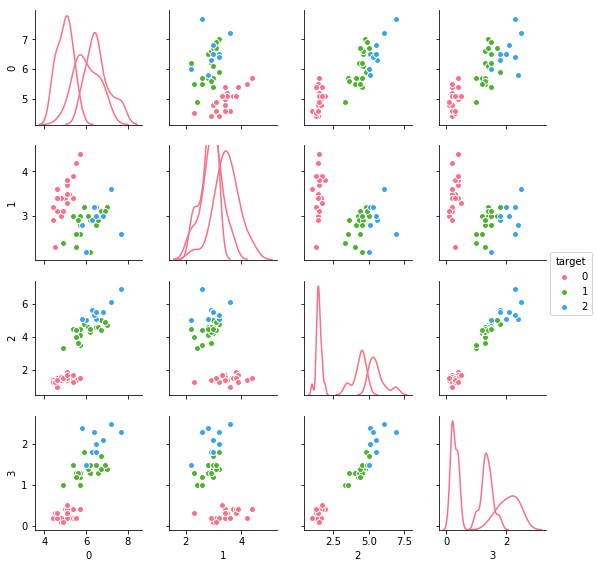

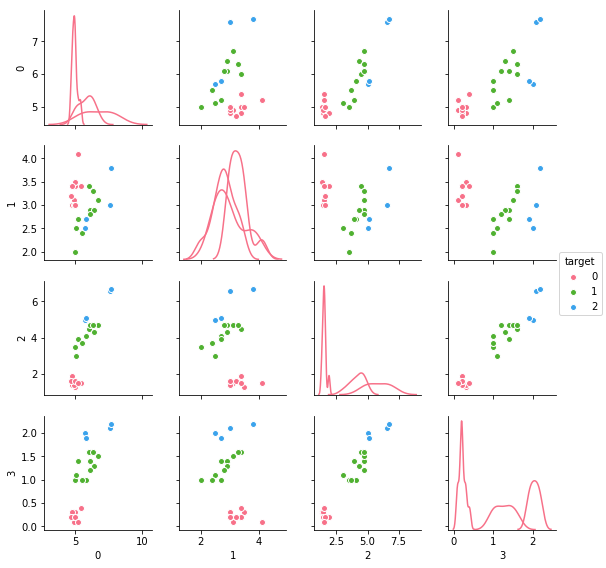

In [141]:
plot_samples(est, X, y)